In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm, gaussian_kde
from scipy.fft import fft
from scipy.fftpack import fftshift
from scipy.integrate import dblquad, cumtrapz
from scipy.special import sph_harm
from scipy.linalg import eig, cholesky, solve
from scipy.sparse.linalg import cg
from scipy.interpolate import interp1d
from itertools import combinations_with_replacement
from copy import deepcopy
import time
from scipy.linalg import LinAlgError
from timeit import timeit
import gc

# This first section explores gibbs sampling using a bivariate gaussian.

In [2]:
# Just gets the time in hours, minutes, seconds for use later
def get_time():
    return(time.strftime("%H:%M:%S", time.localtime()))

# This is a useful class for messing around with gibbs sampling a bivariate gaussian

In [3]:
class biv_gauss:
    
    def __init__(self, mean=None, cov=None):
        self.mn = multivariate_normal(mean=mean, cov=cov)
        self.rho = self.mn.cov[0, 1] / np.sqrt(self.mn.cov[0, 0] * self.mn.cov[1, 1])
        
    def get_cond_sample(self, given_var_ind, given_val):
        sample_ind = 1 - given_var_ind
        mu = self.mn.mean[sample_ind] + self.rho * \
            np.sqrt(cov[sample_ind, sample_ind] / cov[given_var_ind, given_var_ind])  * \
            (given_val - self.mn.mean[given_var_ind])
        sigma = np.sqrt(self.mn.cov[sample_ind, sample_ind] * (1 - self.rho**2))
        
        new_sample = np.random.normal(loc=mu, scale=sigma)
        
        return(new_sample)
    
    def get_gibbs_samples(self, start_var_ind, start_sample, size=int(1e6)):
        given_var_ind = start_var_ind
    
        samples = np.zeros([size, 2])
        samples[0, :] = start_sample
        
        given_sample = start_sample[start_var_ind]
        
        for ind in range(1, size):
            new_sample = self.get_cond_sample(given_var_ind, given_sample)
            other_ind = 1 - given_var_ind
            samples[ind, given_var_ind] = given_sample
            samples[ind, other_ind] = new_sample  
            given_var_ind = 1 - given_var_ind
            given_sample = new_sample
            
        return(samples)

# Define a bivariate gaussian with mean and covariance specified by the variables "mean" and "cov." Use a highly correlated one so that we can see if the obvious correlation structure exists.

In [4]:
mean = np.array([0, 0])
cov = np.array([[1,0.9], [0.9,1]])

bg = biv_gauss(mean=mean, cov=cov)
test_samples = np.random.multivariate_normal(mean, cov, size=int(1e6))
gibbs_samples = bg.get_gibbs_samples(0, test_samples[0])
    

# Compare gibbs samples to equivalent samples generated from np.random.multivariate_normal. Histograms look identical, implying the gibbs sampler is probably doing the right thing.

Text(0.5, 1.0, 'Histogram of equivalent numpy call')

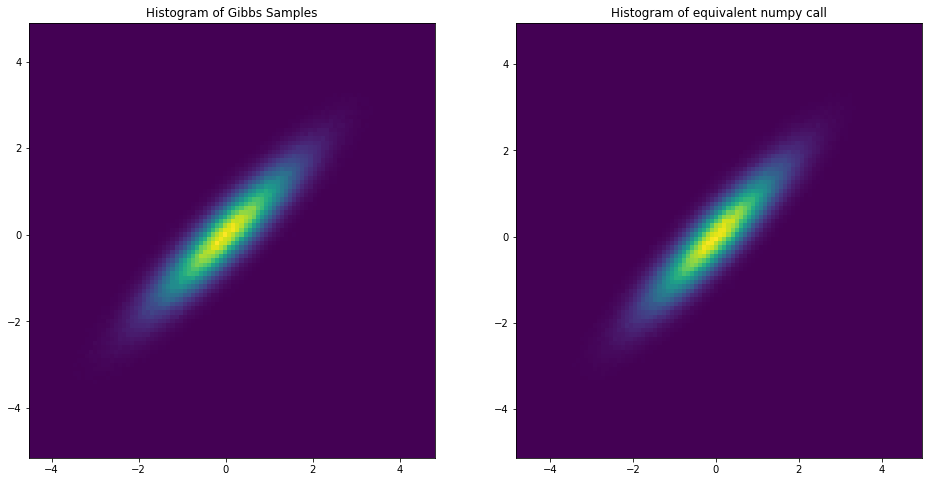

In [5]:
fig, ax = plt.subplots(figsize=(16, 8), ncols=2)
_, _, _, _ = ax[0].hist2d(gibbs_samples[:, 0], gibbs_samples[:, 1],
                          bins=100)
ax[0].set_title("Histogram of Gibbs Samples")
_, _, _, _ = ax[1].hist2d(test_samples[:, 0], test_samples[:, 1], bins=100)

ax[1].set_title("Histogram of equivalent numpy call")

# Make a 2d trace plot. Color is the index of the sample.

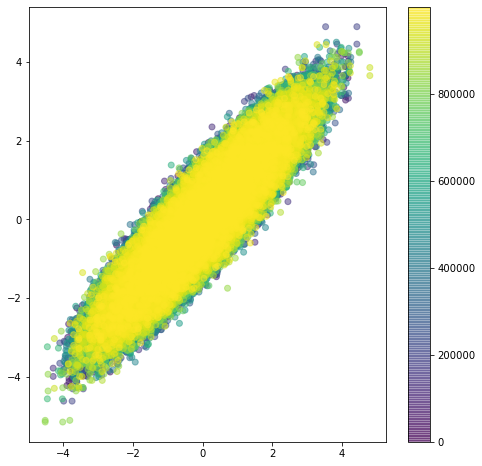

In [6]:
plt.figure(figsize=(8, 8))
plt.scatter(gibbs_samples[:, 0], gibbs_samples[:, 1], c=np.arange(1e6),
            alpha=0.5)
plt.colorbar()

# Calculate the autocorrelation function of the samples. Should see a notable correlation length since this is a centered gibbs sampler.

In [7]:
corr_len = int(1e3)

corr_x = np.correlate(gibbs_samples[:corr_len, 0], gibbs_samples[:corr_len, 0], mode='full')
corr_y = np.correlate(gibbs_samples[:corr_len, 1], gibbs_samples[:corr_len, 1], mode='full')

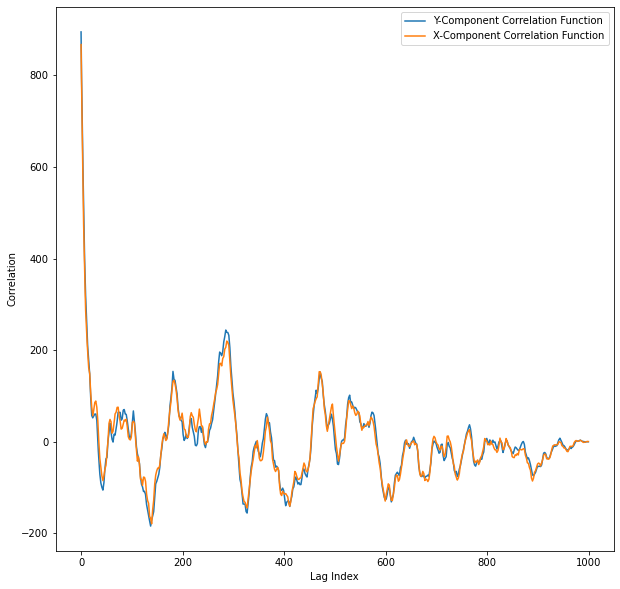

In [8]:
plt.figure(figsize=(10, 10))
plt.plot(fftshift(corr_y)[:1000], label="Y-Component Correlation Function")
plt.plot(fftshift(corr_x)[:1000], label="X-Component Correlation Function")
plt.ylabel("Correlation")
plt.xlabel("Lag Index")
plt.legend()

# Check out the power spectrum of the x-component autocorrelation, to examine the apparent periodicity in the autocorrelation function. PS clearly has some peaks.

Text(0.5, 1.0, 'Max at 8')

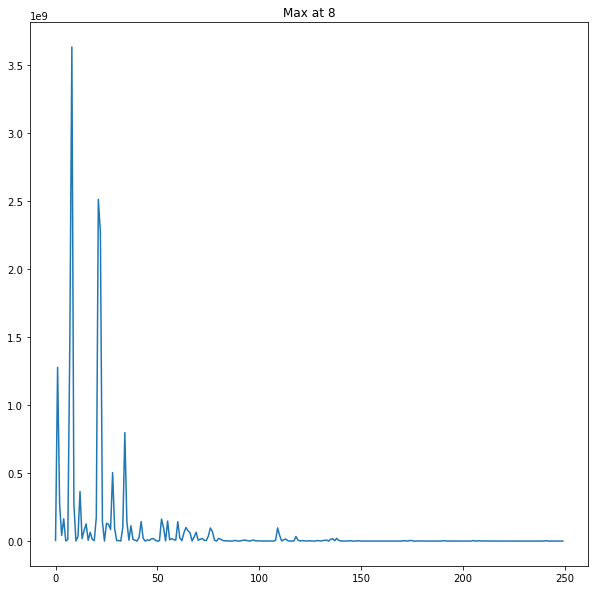

In [9]:
ps = np.abs(fft(corr_x))**2
plt.figure(figsize=(10, 10))
plt.plot(ps[:250])
plt.title(f"Max at {np.argmax(ps)}")

# Power Law Toy Problem: Gibbs sample the joint posterior distribution of the skymap (spherical harmonic) and spectral index parameter, given some pixel values. Just one spectral index for the whole sky. The class below handles all the math in my note. Notable way to speed things up is to use a Healpix-based framework.

In [10]:
class sph_harm_mats:
    
    def __init__(self, a_lm, thetas=np.linspace(0, np.pi, num=10),
                 phis=np.linspace(0, 2 * np.pi, num=10),
                 nus=np.arange(180, 190), G=1, beta=-2, nu_0=185,
                 noise_cov=None, prior_betas=None, prior_mean=None,
                 prior_cov=None):
        """
        Class for handling inference of the joint posterior between
        the spherical harmonic coefficients of the sky intensity
        and the spectral index (const. over sky).
        
        Parameters:
            a_lm (dict): Dictionary of input (true) spherical harmonic
                coefficients. Dict key is a tuple of (l, m), dict value is
                the complex value of the coefficient. These are used in
                conjunction with the noise_cov parameter to generate the
                initial data from which the inference is performed.
            thetas (arr): The polar angles on the sky used in the simulation,
                i.e. 90 - dec but in radians
            phis (arr): The azimuthal angle on the sky used in the simulation
                i.e. RA but in radians.
            nus (arr): The frequencies used in the simulation, in MHz.
            G: Antenna gain. Could potentially be frequency dependent, 
                but there is currently no inference framework for that.
            beta (float): The spectral index used in the simulation. Could
                potentially vary over the sky, but additional machinery would
                be required.
            noise_cov (1-d arr): Noise covariance between pixels (and 
                frequencies). Currently only accepts diagonal
                covariance matrices in the form of a 1-d arr.
                This means pixel-to-pixel correlation is ignored but
                the noise levels on each pixel can vary. Default gives
                identity. Wrapping convention is given by
                np.meshgrid(thetas, phis, nus)
            prior_betas: The beta values used for the inversion sampler.
                You want the coarsest beta sampling that gives you a 
                reasonably smooth estimation of the beta posterior CDF.
            prior_mean: Mean of the spherical harmonic coefficient 
                prior pdf (implicitly gaussian if not None)
            prior_cov: covariance of the spherical harmonic coefficient
                prior pdf (implicitly gaussian if not None).
        """
        if isinstance(a_lm, dict):
            # keys should be (l, m)
            self.a_lm = a_lm
            self.n_alm = len(self.a_lm.keys())
        else:
            raise ValueError("a_lm must be a dict since coefficients can be arbitrary")
            
        self.prior_mean = prior_mean
        self.prior_cov = prior_cov
        if self.prior_cov is not None:
            self.prior_inv_cov = np.linalg.inv(prior_cov)
        else:
            self.prior_inv_cov = None
            
        # Number of voxels
        self.N_vox = len(thetas) * len(phis) * len(nus)
        
        self.thetas, self.phis, self.nus = np.meshgrid(thetas, phis, nus)
        self.thetas = self.thetas.flatten()
        self.phis = self.phis.flatten()
        self.nus = self.nus.flatten()
        
        self.sph_harm_arr = self.get_sph_harm_arr()
        
        
        
        # plaw params
        self.nu_0 = nu_0
        self.beta = beta
        # Can be an integer or frequency-dependent gains
        self.G = G
        
        if noise_cov is None:
            self.noise_cov = np.ones(self.N_vox)
        elif len(noise_cov.shape) > 1:
            raise ValueError("We currently only take diagonal covariance matrices as vector inputs.")
        else:
            self.noise_cov = noise_cov
        self.inv_noise_cov = 1/self.noise_cov
        
        self.update_model(a_lm=self.a_lm, beta=self.beta)
        if prior_betas is None:
            self.prior_betas = np.linspace(self.beta - 0.5, self.beta + 0.5, num=100)
        else:
            self.prior_betas = prior_betas 
        
        # Cache a bunch of things that only need to be computed once
        self.plaw_gain_prior = self.get_plaw_gain(use_prior_betas=True)
        # Has shape Nbeta by N_vox by n_alm
        self.gain_Y_cache = np.einsum('ij,jk->ijk', self.plaw_gain_prior, self.sph_harm_arr)
        self.Jeff_prior_cache = np.transpose(np.log(self.nus / self.nu_0)*np.transpose(self.gain_Y_cache,
                                                                                       axes=(0, 2, 1)),
                                             axes=(0, 2, 1))
        if self.prior_mean is not None:
            self.prior_mean_cache = self.prior_inv_cov @ self.prior_mean
        self.inv_cov_data_cache = self.inv_noise_cov * self.data
        
        
        self.a_lm_samples = []
        self.beta_samples = []
        
    def update_model(self, a_lm=None, beta=None):
        if beta is not None:
            self.beta = beta
            self.plaw_gain = self.get_plaw_gain()
            self.basis_arr = self.get_basis_arr()
            if not hasattr(self, 'data'):
                self.model_vals = self.get_model_vals() # Will do this twice in init :(
                self.data = self.generate_data()
        if a_lm is not None:
            self.a_lm = a_lm
        
            
            
    def get_sph_harm_arr(self):

        sph_harm_arr = np.zeros((self.N_vox, self.n_alm), dtype=complex)
        for a_lm_ind, (l, m) in enumerate(self.a_lm.keys()):
            sph_harm_arr[:, a_lm_ind] = sph_harm(m, l, self.phis, self.thetas)   
        
        return(sph_harm_arr)
    
    def get_plaw_gain(self, use_prior_betas=False):
        if use_prior_betas:
            # Will be shape Nbeta by Nvox
            beta = np.repeat(self.prior_betas[:, np.newaxis], self.N_vox, axis=1)
        else:
            beta=self.beta
        
        plaw_gain = self.G * (self.nus / self.nu_0)**beta
        return(plaw_gain)
                
                
    def get_basis_arr(self, use_prior_betas=False):

        # dims should be N_vox by n_alm
        basis_arr = (self.plaw_gain * self.sph_harm_arr.T).T

        return(basis_arr)
        
    
        
    def get_a_lm_bundle(self):
        
        basis_arr_adj = np.conj(self.basis_arr.T)
        cov_inv = (basis_arr_adj * self.inv_noise_cov) @ self.basis_arr
        if self.prior_cov is not None:
            cov_inv += self.prior_inv_cov
        
        cho_inv = cholesky(cov_inv)
        
        mean = basis_arr_adj@self.inv_cov_data_cache
        if hasattr(self, "prior_mean_cache"):
            mean += self.prior_mean_cache
        
                        
        return(mean, cov_inv, cho_inv)
            
    def generate_data(self):
        data = self.model_vals + np.random.normal(scale=self.noise_cov) + 1.0j * np.random.normal(scale=self.noise_cov)
        return(data)
    
    def get_model_vals(self, use_prior_betas=False):
        if not use_prior_betas:
            model_vals = self.basis_arr @ list(self.a_lm.values())
        else:
            # Shape on return will be Nbeta by Nvox
            model_vals = self.gain_Y_cache @ list(self.a_lm.values())
        
        return(model_vals)
        
    def get_a_lm_sample(self):
        std_norm = np.random.normal(size=self.n_alm) + 1.0j * np.random.normal(size=self.n_alm)
        mean, cov_inv, cho_inv = self.get_a_lm_bundle()
        sample, code = cg(cov_inv, mean + cho_inv @ std_norm)
        assert (code == 0), "Exit code >0, sample wasn't good"
        return(sample)
        
    
    def get_beta_prior(self, use_Jeff_prior):
        # special model vals go over multiple betas, have shape Nbetas, Nvox
        if use_Jeff_prior:
            vec = self.Jeff_prior_cache @ list(self.a_lm.values())
            prior = np.sqrt(np.sum(np.abs(vec**2) * self.inv_noise_cov, axis=1))
        else:
            prior = 1
        
        return(prior)
    
    def get_like(self, special_model_vals=None):
        if special_model_vals is None:
            r = self.data - self.model_vals
            logl = -np.sum(np.abs(r)**2 * self.inv_noise_cov)
        else:
            special_data = np.repeat(self.data[np.newaxis, :], len(self.prior_betas), axis=0)
            # shape Nbeta, Nvox
            r = special_data - special_model_vals
            logl = -np.sum(np.abs(r)**2 * self.inv_noise_cov, axis=1)            
            
        # renormalize to make it more stable
        logl = logl - np.amax(logl)
        like = np.exp(logl)
        
        return(like)
    
    def get_beta_post(self, use_Jeff_prior=True):
        
        special_model_vals = self.get_model_vals(use_prior_betas=True)
        prior = self.get_beta_prior(use_Jeff_prior)
        like = self.get_like(special_model_vals=special_model_vals)
        post_unnorm = like * prior
        post_norm = post_unnorm / np.trapz(post_unnorm, x=self.prior_betas)
        
        return(post_norm)
        
    def get_beta_sample(self, use_Jeff_prior=True, use_interp=True):
        
        beta_post = self.get_beta_post(use_Jeff_prior)
        
        cdf = cumtrapz(beta_post, x=self.prior_betas)
        cdf = np.append(0, cdf)
        u = np.random.uniform()
        if use_interp:
            interp = interp1d(cdf, self.prior_betas)
            new_beta = interp(u)
        else:
            ind = np.argmax(cdf > u)
            new_beta = self.prior_betas[ind]
        
        return(new_beta)
    
    def get_gibbs_samples(self, use_Jeff_prior=True, N_iter=int(1e4),
                          use_interp=True):
        """
        Gibbs sample the joint posterior starting from the current a_lm
        values. Alternates between sampling the spectral index
        conditional on the a_lm's and the joint a_lm's conditional on the
        spectral index.
        
        Parameters:
            use_Jeff_prior: Whether to use a Jeffreys prior on the
                spectral index parameter. If False, then it will use a
                flat prior instead (default is True).
            N_iter: Number of (joint) samples to draw.
            use_interp: Whether to use interpolation to do the inversion
                sampling of the spectral index. Recommended true.
        """
        
        if not isinstance(N_iter, int):
            N_iter = int(N_iter)
        for iter_ind in range(N_iter):
            new_a_lm_sample = self.get_a_lm_sample()
            a_lm_dict = dict(zip(self.a_lm.keys(), new_a_lm_sample))
            self.a_lm_samples.append(new_a_lm_sample)
            self.update_model(a_lm=a_lm_dict)
            
            new_beta_sample = self.get_beta_sample(use_Jeff_prior=use_Jeff_prior, use_interp=use_interp)
            self.beta_samples.append(new_beta_sample)
            self.update_model(beta=new_beta_sample)

In [11]:


def get_a_lm_true(l_max, comp=True):
    """
    Generate some random a_lm's to use
    
    Parameters:
        l_max: maximum l-mode to use
        comp: Whether they should be complex-valued.
    """
    a_lm_true = {}
    
    if comp:
        for l in range(l_max + 1):
            for m in range(l + 1):
                new_comp = np.random.normal() + 1.0j * np.random.normal()
                if m == 0:
                    a_lm_true[(l, m)] = np.real(new_comp)
                elif (m % 2 == 1): # m is odd, phase must be pi/2 + n*pi
                    a_lm_true[(l, m)] = 0.5j * np.imag(new_comp)
                    a_lm_true[(l, -m)] = 0.5j * np.imag(new_comp)
                else: # m is even, 
                    a_lm_true[(l, m)] = 0.5 * new_comp
                    a_lm_true[(l, -m)] = 0.5 * np.conj(new_comp)
    else:
        for l in range(l_max + 1):
            for m in range(l + 1):
                new_sample = np.random.normal(loc=1, scale=0.01)
                a_lm_true[(l, m)] = new_sample
                a_lm_true[(l, -m)] = new_sample
                
    l_vals = []

                    
    return(a_lm_true)

l_max = 5
a_lm_true = get_a_lm_true(l_max)
num_angle = 16
num_freq = 8
noise_level = 0.01
thetas = np.linspace(0, np.pi, num=num_angle)
phis = np.linspace(0, 2*np.pi, num=num_angle)
nus = np.linspace(190, 200, num=num_freq)

# Test interpolate speed

In [12]:
num_coeff = len(list(a_lm_true.keys()))
#del shm_mat

shm_mat = sph_harm_mats(a_lm_true, thetas=thetas, nus=nus, phis=phis,
                        noise_cov=noise_level*np.ones(num_angle**2 * num_freq),
                        beta=-0.5, prior_mean=list(a_lm_true.values()), prior_cov=np.eye(num_coeff),
                        prior_betas=np.linspace(-1, -0, num=128))

%timeit shm_mat.get_gibbs_samples(N_iter=1)
%timeit shm_mat.get_a_lm_sample()
%timeit shm_mat.get_beta_sample()

The slowest run took 4.72 times longer than the fastest. This could mean that an intermediate result is being cached.
57 ms ± 40.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.46 ms ± 774 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
35.8 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
num_coeff = len(list(a_lm_true.keys()))
del shm_mat

shm_mat = sph_harm_mats(a_lm_true, thetas=thetas, nus=nus, phis=phis,
                        noise_cov=noise_level*np.ones(num_angle**2 * num_freq),
                        beta=-0.5, prior_mean=list(a_lm_true.values()), prior_cov=np.eye(num_coeff),
                        prior_betas=np.linspace(-1, -0, num=512))

%timeit shm_mat.get_gibbs_samples(N_iter=1, use_interp=False)
%timeit shm_mat.get_a_lm_sample()
%timeit shm_mat.get_beta_sample(use_interp=False)


119 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.77 ms ± 460 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
100 ms ± 9.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
num_coeff = len(list(a_lm_true.keys()))
del shm_mat

shm_mat = sph_harm_mats(a_lm_true, thetas=thetas, nus=nus, phis=phis,
                        noise_cov=noise_level*np.ones(num_angle**2 * num_freq),
                        beta=-0.5, prior_mean=list(a_lm_true.values()), prior_cov=np.eye(num_coeff),
                        prior_betas=np.linspace(-1, -0, num=512))

%timeit shm_mat.get_gibbs_samples(N_iter=1, use_interp=True)
%timeit shm_mat.get_a_lm_sample()
%timeit shm_mat.get_beta_sample(use_interp=True)

109 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.46 ms ± 48.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
107 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Above shows that interpolating on 4x smaller grid is much faster than doing naive inversion. Interp is also about as fast as naive inversion, and more principled. So, probably better to just do that.

# Test interp bias?

mu: -0.5583348604422418


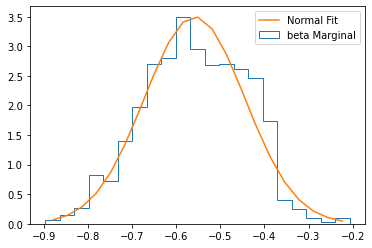

In [15]:
num_coeff = len(list(a_lm_true.keys()))
del shm_mat

shm_mat = sph_harm_mats(a_lm_true, thetas=thetas, nus=nus, phis=phis,
                        noise_cov=noise_level*np.ones(num_angle**2 * num_freq),
                        beta=-0.5, prior_mean=list(a_lm_true.values()), prior_cov=np.eye(num_coeff),
                        prior_betas=np.linspace(-1, -0, num=128))

shm_mat.beta_samples = []
shm_mat.a_lm_samples = []

shm_mat.get_gibbs_samples(N_iter=1000)

mu = np.mean(shm_mat.beta_samples)
sig = np.sqrt(np.var(shm_mat.beta_samples))
print(f"mu: {mu}")

counts, bins, _ = plt.hist(shm_mat.beta_samples, bins='auto', histtype='step', log=False, density=True,
                           label="beta Marginal")
bin_cent = 0.5 * (bins[:-1] + bins[1:])
norm_pdf = norm.pdf(bin_cent, loc=mu, scale=sig)
plt.plot(bin_cent, norm_pdf, label="Normal Fit")
plt.legend()

mu: -0.5549569471624266


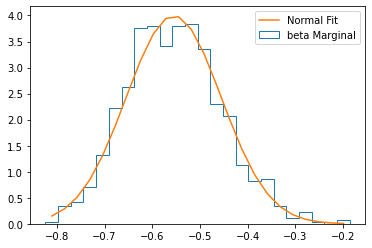

In [16]:
num_coeff = len(list(a_lm_true.keys()))
del shm_mat

shm_mat = sph_harm_mats(a_lm_true, thetas=thetas, nus=nus, phis=phis,
                        noise_cov=noise_level*np.ones(num_angle**2 * num_freq),
                        beta=-0.5, prior_mean=list(a_lm_true.values()), prior_cov=np.eye(num_coeff),
                        prior_betas=np.linspace(-1, -0, num=512))

shm_mat.beta_samples = []
shm_mat.a_lm_samples = []

shm_mat.get_gibbs_samples(N_iter=1000, use_interp=False)

mu = np.mean(shm_mat.beta_samples)
sig = np.sqrt(np.var(shm_mat.beta_samples))
print(f"mu: {mu}")

counts, bins, _ = plt.hist(shm_mat.beta_samples, bins='auto', histtype='step', log=False, density=True,
                           label="beta Marginal")
bin_cent = 0.5 * (bins[:-1] + bins[1:])
norm_pdf = norm.pdf(bin_cent, loc=mu, scale=sig)
plt.plot(bin_cent, norm_pdf, label="Normal Fit")
plt.legend()

mu: -0.533157390945776


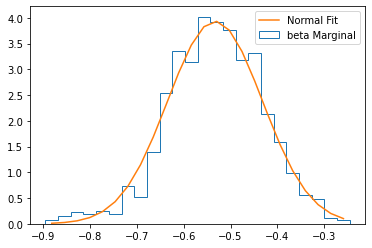

In [17]:
num_coeff = len(list(a_lm_true.keys()))
del shm_mat

shm_mat = sph_harm_mats(a_lm_true, thetas=thetas, nus=nus, phis=phis,
                        noise_cov=noise_level*np.ones(num_angle**2 * num_freq),
                        beta=-0.5, prior_mean=list(a_lm_true.values()), prior_cov=np.eye(num_coeff),
                        prior_betas=np.linspace(-1, -0, num=512))

shm_mat.beta_samples = []
shm_mat.a_lm_samples = []

shm_mat.get_gibbs_samples(N_iter=1000)

mu = np.mean(shm_mat.beta_samples)
sig = np.sqrt(np.var(shm_mat.beta_samples))
print(f"mu: {mu}")

counts, bins, _ = plt.hist(shm_mat.beta_samples, bins='auto', histtype='step', log=False, density=True,
                           label="beta Marginal")
bin_cent = 0.5 * (bins[:-1] + bins[1:])
norm_pdf = norm.pdf(bin_cent, loc=mu, scale=sig)
plt.plot(bin_cent, norm_pdf, label="Normal Fit")
plt.legend()

# Bias is equally present in all three cases if the mean beta is used as the estimate for beta. Suggests that we can probably get away with relatively coarse beta grids for inversion sampling.

In [18]:
del shm_mat
gc.collect()

21

# Check timing for higher l_max. In this case there are $26^2=676$ a_lm's and a beta grid of size 64. Sometimes run into memory issues. Timeit will complain about a result being cached. For this reason, I've timed the sampling steps individually for each conditional along with the total Gibbs loop, for comparison.

In [20]:


l_max = 26
a_lm_true = get_a_lm_true(l_max)
num_coeff = len(list(a_lm_true.keys()))

shm_mat = sph_harm_mats(a_lm_true, thetas=thetas, nus=nus, phis=phis,
                        noise_cov=noise_level*np.ones(num_angle**2 * num_freq),
                        beta=-0.5, prior_mean=list(a_lm_true.values()),
                        prior_cov=np.eye(num_coeff),
                        prior_betas=np.linspace(-1, -0, num=64))



%timeit shm_mat.get_gibbs_samples(N_iter=1, use_interp=True)
%timeit shm_mat.get_a_lm_sample()
%timeit shm_mat.get_beta_sample(use_interp=True)

322 ms ± 9.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
194 ms ± 56.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 9.35 times longer than the fastest. This could mean that an intermediate result is being cached.
486 ms ± 396 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Do a 2-d histogram of a particular a_lm and beta, to see if it explains the bias. Have also seen a malfunction when l_max is too high. Not sure what to do about that yet. The spectral index marginal gets skewed very negative. 

In [21]:


del shm_mat

l_max = 5
a_lm_true = get_a_lm_true(l_max)
num_coeff = len(list(a_lm_true.keys()))
num_angle = 16
num_freq = 8
noise_level = 0.01
thetas = np.linspace(0, np.pi, num=num_angle)
phis = np.linspace(0, 2*np.pi, num=num_angle)
nus = np.linspace(190, 200, num=num_freq)

shm_mat = sph_harm_mats(a_lm_true, thetas=thetas, nus=nus, phis=phis,
                        noise_cov=noise_level*np.ones(num_angle**2 * num_freq),
                        beta=-0.5, prior_mean=list(a_lm_true.values()), prior_cov=np.eye(num_coeff),
                        prior_betas=np.linspace(-1, -0, num=256))

shm_mat.get_gibbs_samples(N_iter=1e4)

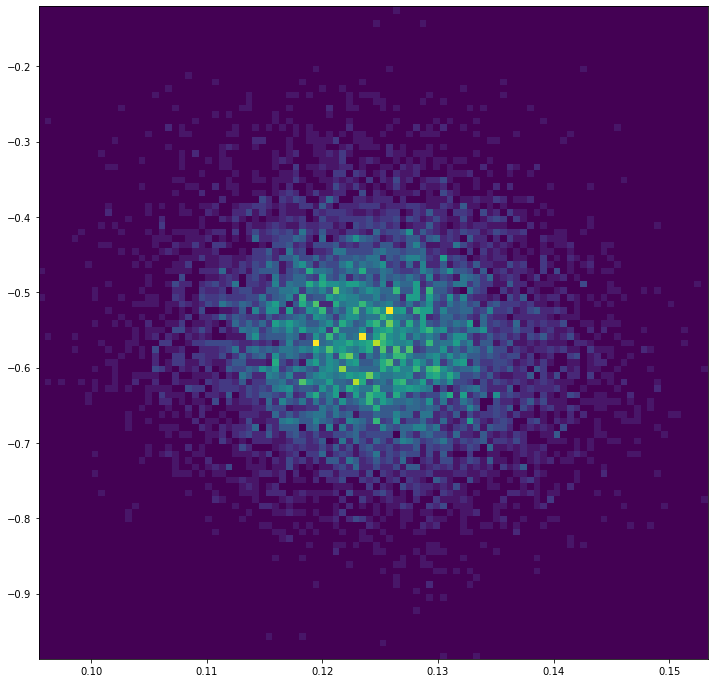

In [22]:
plt.figure(figsize=(12, 12))
xdat = [np.abs(sample[9]) for sample in shm_mat.a_lm_samples]
ydat = shm_mat.beta_samples

counts, _, _, _= plt.hist2d(xdat, ydat, bins=100, density=True)

# Do a contour over the histogram. This cell has some hardcoding which might cause a bad result if it is rerun with a different seed.

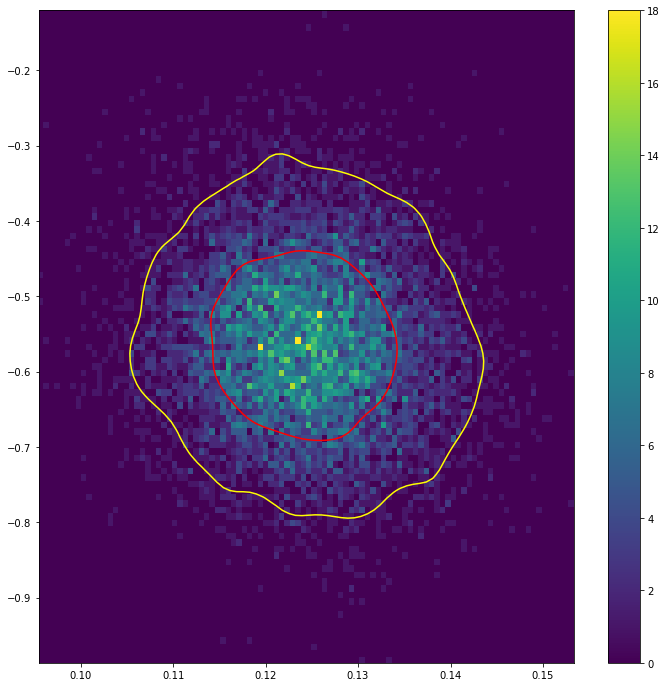

In [23]:
plt.figure(figsize=(12, 12))
xdat = [np.abs(sample[9]) for sample in shm_mat.a_lm_samples]
ydat = shm_mat.beta_samples

points = np.array([xdat, ydat])

#counts, xedges, yedges, Image = plt.hist2d(xdat, ydat, bins=100, density=True)
kde = gaussian_kde(points)


xrange = np.linspace(0.09, 0.16, num=100)
yrange = np.linspace(-1, 0, num=100)
xx, yy = np.meshgrid(xrange, yrange)

z = np.reshape(kde(np.array([xx.ravel(), yy.ravel()])).T, xx.shape)
z = z/z.sum()

n = 1000
t = np.linspace(0, z.max(), n)
mask = (z >= t[:, None, None])
integral = (mask * z).sum(axis=(1, 2))
    
f = interp1d(integral, t)
t_contours = f(np.array([0.9, 0.5]))

plt.contour(xx,yy, z, t_contours, colors=['yellow', 'red'])
#plt.pcolormesh(xx, yy, z, cmap='gray')
plt.hist2d(xdat, ydat, bins=100)
plt.colorbar()



# Plot the marginal, check if its Gaussian

In [24]:
print(len(ydat))

10000


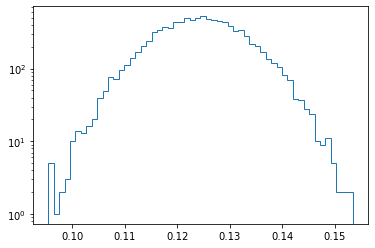

In [25]:
_, _, _ = plt.hist(xdat, bins='auto', histtype='step', log=True)

# Do a mock skymap recovery. Depending on settings this can look somewhat "miraculous" e.g. if the prior is overrestrictive and happens to be correct. Also only one frequency is shown, and if there are enough frequencies, it can be the case that the a_lm's are well-known when combining information across frequencies when any one frequency looks muddled. This only has 10 samples, so the sample error should actually be quite high. Probably what is happening is that it is starting off near the correct answer and doesn't have long enough to wander.

Text(0.5, 1.05, 'Fractional Error Between True and Recovered')

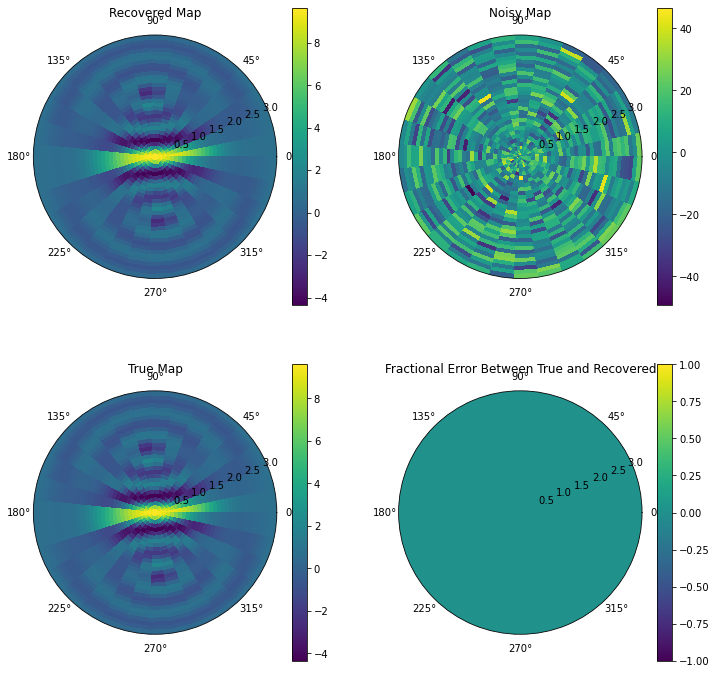

In [26]:
l_max = 10
a_lm_true = get_a_lm_true(l_max, comp=False)
#a_lm_true = {key: 0 for key in a_lm_true.keys()}
num_angle = 32
num_freq = 16
noise_level = 16
thetas = np.linspace(0, np.pi, num=num_angle)
phis = np.linspace(0, 2*np.pi, num=num_angle)
nus = np.linspace(190, 200, num=num_freq)

shm_mat = sph_harm_mats(a_lm_true, thetas=thetas, nus=nus, phis=phis,
                        noise_cov=noise_level*np.ones(num_angle**2 * num_freq),
                        beta=-0.5, prior_mean=list(a_lm_true.values()),
                        prior_cov=1e16*np.eye((l_max + 1)**2),
                        prior_betas=np.linspace(-1, 0, num=128))
shm_mat.get_gibbs_samples(N_iter=10)

a_lm_mean = np.mean(shm_mat.a_lm_samples, axis=0)
beta_mean = np.mean(shm_mat.beta_samples)

a_lm_update = dict(zip(shm_mat.a_lm.keys(), a_lm_mean))

nu_ind = 0
wh_coord = np.where(shm_mat.nus == shm_mat.nus[nu_ind])
plot_thetas = shm_mat.thetas[wh_coord]
plot_phis = shm_mat.phis[wh_coord]
plot_phis= plot_phis.reshape((32, 32))
plot_thetas = plot_thetas.reshape((32, 32))



fig = plt.figure(figsize=(12, 12))
fig.add_subplot(221, polar='True')
shm_mat.update_model(a_lm=a_lm_update, beta=beta_mean)
plt.pcolormesh(plot_phis, plot_thetas, shm_mat.model_vals[wh_coord].real.reshape((32, 32)))
store_model = deepcopy(shm_mat.model_vals[wh_coord].real.reshape((32, 32)))
plt.colorbar()
plt.title("Recovered Map")

fig.add_subplot(222, polar='True')
plt.pcolormesh(plot_phis, plot_thetas, shm_mat.data[wh_coord].real.reshape((32, 32)))
plt.colorbar()
plt.title("Noisy Map")

shm_mat.update_model(a_lm=a_lm_true, beta=-0.5)
shm_mat.update_model(a_lm=a_lm_true, beta=beta_mean)
fig.add_subplot(223, polar='True')
plt.pcolormesh(plot_phis, plot_thetas, shm_mat.model_vals[wh_coord].real.reshape((32, 32)))
plt.colorbar()
plt.title("True Map")

fig.add_subplot(224, polar='True')
res = store_model - shm_mat.model_vals[wh_coord].real.reshape((32, 32))
plt.pcolormesh(plot_phis, plot_thetas, np.abs(res) / shm_mat.model_vals[wh_coord].real.reshape((32, 32)),
               vmin=-1, vmax=1)
plt.colorbar()
plt.title("Fractional Error Between True and Recovered")


# Do it with 100 samples

In [27]:
l_max = 10
a_lm_true = get_a_lm_true(l_max, comp=False)
#a_lm_true = {key: 0 for key in a_lm_true.keys()}
num_angle = 32
num_freq = 16
noise_level = 16
thetas = np.linspace(0, np.pi, num=num_angle)
phis = np.linspace(0, 2*np.pi, num=num_angle)
nus = np.linspace(190, 200, num=num_freq)
N_iter=100

shm_mat = sph_harm_mats(a_lm_true, thetas=thetas, nus=nus, phis=phis,
                        noise_cov=noise_level*np.ones(num_angle**2 * num_freq),
                        beta=-0.5,# prior_mean=list(a_lm_true.values()), prior_cov=1e16*np.eye((l_max + 1)**2),
                        prior_betas=np.linspace(-1, 0, num=128))
shm_mat.get_gibbs_samples(N_iter=N_iter)

a_lm_mean = np.mean(shm_mat.a_lm_samples, axis=0)
beta_mean = np.mean(shm_mat.beta_samples)

a_lm_update = dict(zip(shm_mat.a_lm.keys(), a_lm_mean))

nu_ind = 0
wh_coord = np.where(shm_mat.nus == shm_mat.nus[nu_ind])
plot_thetas = shm_mat.thetas[wh_coord]
plot_phis = shm_mat.phis[wh_coord]
plot_phis= plot_phis.reshape((32, 32))
plot_thetas = plot_thetas.reshape((32, 32))



fig = plt.figure(figsize=(12, 12))
fig.add_subplot(221, polar='True')
shm_mat.update_model(a_lm=a_lm_update, beta=beta_mean)
plt.pcolormesh(plot_phis, plot_thetas, shm_mat.model_vals[wh_coord].real.reshape((32, 32)))
store_model = deepcopy(shm_mat.model_vals[wh_coord].real.reshape((32, 32)))
plt.colorbar()
plt.title("Recovered Map")

fig.add_subplot(222, polar='True')
plt.pcolormesh(plot_phis, plot_thetas, shm_mat.data[wh_coord].real.reshape((32, 32)))
plt.colorbar()
plt.title("Noisy Map")

shm_mat.update_model(a_lm=a_lm_true, beta=-0.5)
shm_mat.update_model(a_lm=a_lm_true, beta=beta_mean)
fig.add_subplot(223, polar='True')
plt.pcolormesh(plot_phis, plot_thetas, shm_mat.model_vals[wh_coord].real.reshape((32, 32)))
plt.colorbar()
plt.title("True Map")

fig.add_subplot(224, polar='True')
res = store_model - shm_mat.model_vals[wh_coord].real.reshape((32, 32))
plt.pcolormesh(plot_phis, plot_thetas, np.abs(res) / shm_mat.model_vals[wh_coord].real.reshape((32, 32)),
               vmin=-1, vmax=1)
plt.colorbar()
plt.title("Fractional Error Between True and Recovered")

KeyboardInterrupt: 

# Do it with 1000 samples

In [ ]:
del shm_mat
l_max = 10
a_lm_true = get_a_lm_true(l_max, comp=False)
#a_lm_true = {key: 0 for key in a_lm_true.keys()}
num_angle = 32
num_freq = 16
noise_level = 16
thetas = np.linspace(0, np.pi, num=num_angle)
phis = np.linspace(0, 2*np.pi, num=num_angle)
nus = np.linspace(190, 200, num=num_freq)
N_iter=1000

shm_mat = sph_harm_mats(a_lm_true, thetas=thetas, nus=nus, phis=phis,
                        noise_cov=noise_level*np.ones(num_angle**2 * num_freq),
                        beta=-0.5,# prior_mean=list(a_lm_true.values()), prior_cov=1e16*np.eye((l_max + 1)**2),
                        prior_betas=np.linspace(-1, 0, num=128))
shm_mat.get_gibbs_samples(N_iter=N_iter)

a_lm_mean = np.mean(shm_mat.a_lm_samples, axis=0)
beta_mean = np.mean(shm_mat.beta_samples)

a_lm_update = dict(zip(shm_mat.a_lm.keys(), a_lm_mean))

nu_ind = 0
wh_coord = np.where(shm_mat.nus == shm_mat.nus[nu_ind])
plot_thetas = shm_mat.thetas[wh_coord]
plot_phis = shm_mat.phis[wh_coord]
plot_phis= plot_phis.reshape((32, 32))
plot_thetas = plot_thetas.reshape((32, 32))



fig = plt.figure(figsize=(12, 12))
fig.add_subplot(221, polar='True')
shm_mat.update_model(a_lm=a_lm_update, beta=beta_mean)
plt.pcolormesh(plot_phis, plot_thetas, shm_mat.model_vals[wh_coord].real.reshape((32, 32)))
store_model = deepcopy(shm_mat.model_vals[wh_coord].real.reshape((32, 32)))
plt.colorbar()
plt.title("Recovered Map")

fig.add_subplot(222, polar='True')
plt.pcolormesh(plot_phis, plot_thetas, shm_mat.data[wh_coord].real.reshape((32, 32)))
plt.colorbar()
plt.title("Noisy Map")

shm_mat.update_model(a_lm=a_lm_true, beta=-0.5)
shm_mat.update_model(a_lm=a_lm_true, beta=beta_mean)
fig.add_subplot(223, polar='True')
plt.pcolormesh(plot_phis, plot_thetas, shm_mat.model_vals[wh_coord].real.reshape((32, 32)))
plt.colorbar()
plt.title("True Map")

fig.add_subplot(224, polar='True')
res = store_model - shm_mat.model_vals[wh_coord].real.reshape((32, 32))
plt.pcolormesh(plot_phis, plot_thetas, np.abs(res) / shm_mat.model_vals[wh_coord].real.reshape((32, 32)),
               vmin=-1, vmax=1)
plt.colorbar()
plt.title("Fractional Error Between True and Recovered")

# Below here is scratch paper, mostly related to timing.

In [569]:
l_max = 10
a_lm_true = get_a_lm_true(l_max, comp=False)
#a_lm_true = {key: 0 for key in a_lm_true.keys()}
num_angle = 32
num_freq = 16
noise_level = 16
thetas = np.linspace(0, np.pi, num=num_angle)
phis = np.linspace(0, 2*np.pi, num=num_angle)
nus = np.linspace(190, 200, num=num_freq)
N_iter=10

shm_mat = shm_mat = sph_harm_mats(a_lm_true, thetas=thetas, nus=nus, phis=phis,
                                  noise_cov=noise_level*np.ones(num_angle**2 * num_freq),
                                  beta=-0.5, prior_mean=list(a_lm_true.values()), prior_cov=np.eye((l_max + 1)**2),
                                  prior_betas=np.linspace(-1, 0, num=500))

%timeit shm_mat.get_a_lm_mean_cov()
%timeit shm_mat.get_a_lm_sample()
%timeit np.linalg.cholesky(shm_mat.a_lm_cov)
%timeit shm_mat.get_a_lm_sample_solve()


49.7 ms ± 7.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
34.7 µs ± 4.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
262 µs ± 21.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
50.5 ms ± 4.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [558]:
l_max = 50
a_lm_true = get_a_lm_true(l_max, comp=False)
#a_lm_true = {key: 0 for key in a_lm_true.keys()}
num_angle = 32
num_freq = 16
noise_level = 16
thetas = np.linspace(0, np.pi, num=num_angle)
phis = np.linspace(0, 2*np.pi, num=num_angle)
nus = np.linspace(190, 200, num=num_freq)
N_iter=10

shm_mat = shm_mat = sph_harm_mats(a_lm_true, thetas=thetas, nus=nus, phis=phis,
                                  noise_cov=noise_level*np.ones(num_angle**2 * num_freq),
                                  beta=-0.5, prior_mean=list(a_lm_true.values()), prior_cov=np.eye((l_max + 1)**2),
                                  prior_betas=np.linspace(-1, 0, num=500))

%timeit shm_mat.get_a_lm_mean_cov()
%timeit shm_mat.get_a_lm_sample()
%timeit np.linalg.cholesky(shm_mat.a_lm_cov)
%timeit shm_mat.get_a_lm_sample_solve()

18 s ± 648 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.72 ms ± 818 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
547 ms ± 51.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
17.7 s ± 2.53 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [559]:

adj = np.conj(shm_mat.basis_arr).T * shm_mat.inv_noise_cov
vec = adj@shm_mat.data
vec += shm_mat.prior_inv_cov@shm_mat.prior_mean
cov_inv = adj@shm_mat.basis_arr
cov_inv += shm_mat.prior_inv_cov;sample = cg(cov_inv, vec) 

In [560]:
%timeit adj = np.conj(shm_mat.basis_arr).T * shm_mat.inv_noise_cov
%timeit vec = adj@shm_mat.data
#%timeit vec += shm_mat.prior_inv_cov@shm_mat.prior_mean
%timeit cov_inv = np.matmul(adj, shm_mat.basis_arr)
#%timeit cov_inv += shm_mat.prior_inv_cov;
%timeit sample = cg(cov_inv, vec) 

977 ms ± 76.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
35.4 ms ± 8.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.5 s ± 764 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
394 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [571]:
%timeit adj = np.conj(shm_mat.basis_arr).T
%timeit vec = adj@(shm_mat.inv_noise_cov * shm_mat.data)
#%timeit vec += shm_mat.prior_inv_cov@shm_mat.prior_mean
%timeit cov_inv = np.matmul(adj * shm_mat.inv_noise_cov, shm_mat.basis_arr)
#%timeit cov_inv += shm_mat.prior_inv_cov;
%timeit sample = cg(cov_inv, vec) 

10.4 ms ± 2.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 5.51 times longer than the fastest. This could mean that an intermediate result is being cached.
83.9 ms ± 64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.66 s ± 395 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
894 ms ± 207 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [562]:
%timeit np.matmul(np.linalg.inv(cov_inv), vec)

3.14 s ± 240 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [563]:
%timeit np.linalg.inv(cov_inv)

3.55 s ± 429 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [574]:
%timeit np.sum(np.conj(shm_mat.basis_arr.T) * shm_mat.inv_noise_cov * shm_mat.basis_arr.T, axis=1)

33.2 ms ± 3.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [584]:
%timeit np.conj(shm_mat.basis_arr.T)

7.76 ms ± 233 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [585]:
R = np.conj(shm_mat.basis_arr.T)

In [586]:
%timeit R

23 ns ± 0.555 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
